In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from jax import random

In [122]:
def RBF(x1,x2,*,length_scale=1.0):
    return np.exp(-0.5/length_scale**2 * (x1-x2)**2)

def dRBF(x1,x2,*,length_scale=1.0):
    return -(x1-x2)/length_scale**2 * RBF(x1,x2,length_scale=length_scale)

def ddRBF(x1,x2,*,length_scale=1.0):
    return (1 - (x1-x2)**2 / length_scale**2) / length_scale**2 * RBF(x1,x2,length_scale=length_scale)

def covMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = RBF(xs,ys,length_scale=length_scale)
    
    return mat

def dcovMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = dRBF(xs,ys,length_scale=length_scale)
    
    return mat

def ddcovMatrix(reference_points,data_points,*,length_scale=1.0):
    xs,ys = np.meshgrid(data_points,reference_points,sparse=True)
    mat = ddRBF(xs,ys,length_scale=length_scale)
    
    return mat

def sigmaMatrix(sigma_sq,*,size=0):
    if np.isscalar(sigma_sq):
        return np.eye(size) / sigma_sq
    
    return np.diag(1 / sigma_sq)

In [123]:
key = random.PRNGKey(0)

def func(x,noise=0.0):
    return np.sin(x) + noise*random.normal(key, x.shape)

def grad_func(x,noise=0.0):
    return np.cos(x) + noise*random.normal(key, x.shape)

## Sparse GPR

In [124]:
# bounds = np.array([0.0, np.pi])

# noise = 0.1

# length_scale = 1.0

# num_reference_points = 10
# referencegrid = np.linspace(*bounds,num_reference_points)

# num_datapoints = 15
# datagrid = np.random.uniform(*bounds,num_datapoints)
# data_values = func(datagrid,noise)
# derivative_values = grad_func(datagrid,noise)

# num_gridpoints = 101
# grid = np.linspace(*bounds,num_gridpoints)

In [125]:
# K_MM = covMatrix(reference_points=referencegrid,data_points=referencegrid,length_scale=length_scale)
# K_MN = covMatrix(reference_points=referencegrid,data_points=datagrid,length_scale=length_scale)
# DK_MN = dcovMatrix(reference_points=referencegrid,data_points=datagrid,length_scale=length_scale)
# LK = np.concatenate((K_MN,DK_MN),axis=1)

# S_big = sigmaMatrix(noise**2,size=2*num_datapoints)
# S_small = sigmaMatrix(noise**2,size=num_datapoints)
# values = np.concatenate((data_values,derivative_values))

In [126]:
# matrix = K_MM + LK@S_big@LK.T
# vector = LK@S_big@values
# # vector = LK@values
# coeff_mix = solve(matrix,vector)

# matrix = K_MM + DK_MN@S_small@DK_MN.T
# vector = DK_MN@S_small@derivative_values
# # vector = DK_MN@derivative_values
# coeff_der = solve(matrix,vector)

# matrix = K_MM + K_MN@S_small@K_MN.T
# vector = K_MN@S_small@data_values
# # vector = K_MN@data_values
# coeff_val = solve(matrix,vector)

# pred_mix = [coeff_mix@RBF(x,referencegrid) for x in grid]
# pred_der = [coeff_der@RBF(x,referencegrid) for x in grid]
# pred_val = [coeff_val@RBF(x,referencegrid) for x in grid]

In [127]:
# f, ax = plt.subplots(1,3,figsize=(15, 5))
# for i in range(3):
#     ax[i].plot(grid,func(grid),"k--",label="true")
#     ax[i].vlines(referencegrid,0,1,ls="--",colors="grey",lw=0.5,transform=ax[i].get_xaxis_transform(),label="ref grid")
#     ax[i].grid()
#     ax[i].scatter(datagrid,data_values,c="r")
# ax[0].plot(grid,pred_mix,c="b",label="mixed")
# ax[1].plot(grid,pred_der,c="b",label="derivatives")
# ax[2].plot(grid,pred_val,c="b",label="func_evals")
# ax[0].set_title("derivatives + function evals")
# ax[1].set_title("derivatives")
# ax[2].set_title("function evals")

## Full GPR for 1 function value and N derivative values

In [128]:
bounds = np.array([0.0, 2*np.pi])

noise = 0.1

length_scale = 1.0

num_derivpoints = 9
derivgrid = np.linspace(*bounds,num_derivpoints)
derivative_values = grad_func(derivgrid,noise)
num_datapoints = 2
datagrid = np.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)

fullgrid = np.zeros(num_datapoints+num_derivpoints)
full_values = np.zeros(num_datapoints+num_derivpoints)
fullgrid[:num_datapoints] = datagrid
fullgrid[num_datapoints:] = derivgrid
full_values[:num_datapoints] = data_values
full_values[num_datapoints:] = derivative_values

num_gridpoints = 101
grid = np.linspace(*bounds,num_gridpoints)

In [129]:
print(fullgrid)

[0.         6.28318531 0.         0.78539816 1.57079633 2.35619449
 3.14159265 3.92699082 4.71238898 5.49778714 6.28318531]


In [130]:
KV = covMatrix(fullgrid[:num_datapoints],fullgrid[:num_datapoints],length_scale=length_scale)
KD = ddcovMatrix(fullgrid[num_datapoints:],fullgrid[num_datapoints:],length_scale=length_scale)
KM = dcovMatrix(fullgrid[:num_datapoints],fullgrid[num_datapoints:],length_scale=length_scale)

K_NN = np.zeros((num_datapoints+num_derivpoints,)*2)
K_NN[:num_datapoints,:num_datapoints] = KV
K_NN[num_datapoints:,num_datapoints:] = KD
K_NN[:num_datapoints,num_datapoints:] = KM
K_NN[num_datapoints:,:num_datapoints] = KM.T

In [131]:
invert_mat = K_NN + np.eye(num_datapoints+num_derivpoints)*noise**2
pred_coeff = solve(invert_mat,full_values)

prediction = np.zeros_like(grid)
vars = np.zeros_like(grid)

K_M = []

k_vec = np.zeros(num_datapoints+num_derivpoints)

for i,x in enumerate(grid):
    k_vec[:num_datapoints] = RBF(datagrid,x)
    k_vec[num_datapoints:] = dRBF(derivgrid,x)

    K_M.append(k_vec)

    prediction[i] = pred_coeff@k_vec
    vars[i] = RBF(x,x) + noise**2 - k_vec@solve(invert_mat,k_vec)

In [132]:
K_M = np.array(K_M)
print(K_M[0])

[ 2.67528799e-09  1.00000000e+00  1.68093302e-08  1.50234090e-06
  7.09801741e-05  1.75944827e-03  2.25939679e-02  1.46786163e-01
  4.57436206e-01  5.76955803e-01 -0.00000000e+00]


derivgrid must be in first position since the measured values are those from derivatives and dRBF was defined as the derivative w.r. to the first argument!!!

In [133]:
def slope(x,xref,yref,grad):
    return grad*(x-xref) + yref

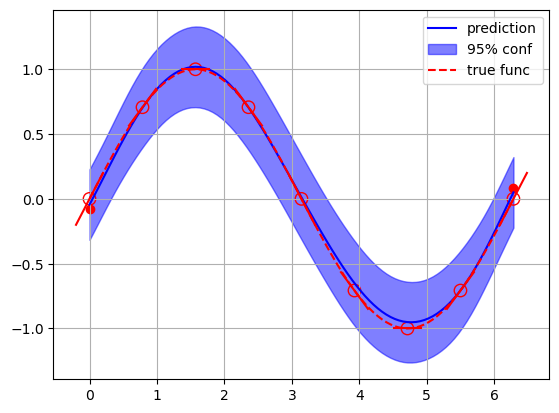

In [134]:
stds = np.sqrt(vars)

plt.plot(grid,prediction,"b",label="prediction")
plt.fill_between(grid,prediction-2*stds,prediction+2*stds,alpha=0.5,color="b",label="95% conf")
plt.scatter(datagrid,data_values,color="r")
for xref in derivgrid:
    slope_range = np.linspace(xref-0.2,xref+0.2,5)
    plt.plot(slope_range,slope(slope_range,xref,func(xref),grad_func(xref)),"r")
    plt.scatter(xref,func(xref),s=80,facecolors="none",edgecolors="r")
plt.plot(grid,func(grid),"r--",label="true func")
plt.grid()
plt.legend()

## Tests on deprecated 1D code

In [135]:
# model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ppa",noise_var=noise**2)
# model.fit(X_data,Y_data)
# (means_ppa, stds_ppa) = model.predict(grid,True)

# model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="sor",noise_var=noise**2)
# model.fit(X_data,Y_data)
# (means_sor, stds_sor) = model.predict(grid,True)

# model = gpr.sparseGPR(gpr.RBF_1D(1.5),num_datapoints,num_derivpoints,referencegrid,sparse_method="ny",noise_var=noise**2)
# model.fit(X_data,Y_data)
# (means_ny, stds_ny) = model.predict(grid,True)

In [136]:
# plt.plot(grid,means_ppa,label="ppa")
# plt.fill_between(grid,means_ppa-stds_ppa,means_ppa+stds_ppa,alpha=0.5)
# plt.plot(grid,means_sor,label="sor")
# plt.fill_between(grid,means_sor-stds_sor,means_sor+stds_sor,alpha=0.5)
# plt.plot(grid,means_ny,label="ny")
# plt.fill_between(grid,means_ny-stds_ny,means_ny+stds_ny,alpha=0.5)
# plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
# plt.scatter(datagrid,data_values,color="r",label="function values")
# plt.grid()
# plt.legend()